In [71]:
import torch
import sys
from tqdm import tqdm
from functools import partial

import clip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sys.path.append('..')
from lidar_clippin.loader import build_loader
from lidar_clippin.helpers import MultiLoader, try_paths, get_topk, get_topk_separate_prompts, logit_img_txt
from lidar_clippin.prompts import WEATHER_PROMPT_TEMPLATES, PERIOD_PROMPT_TEMPLATES, OBJECT_PROMPT_TEMPLATES, BUSY_PROMPTS, EMPTY_PROMPTS

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [5]:
CLIP_VERSION = "ViT-L/14"
USE_COSINE = False
SPLITS = ["val", "test"]
DATASET_NAME = "once"

# Load clip
clip_model, clip_preprocess = clip.load(CLIP_VERSION)
get_topk = partial(get_topk, clip_model=clip_model, device=device)
get_topk_separate_prompts = partial(get_topk_separate_prompts, clip_model=clip_model, device=device)

# Load the dataset
dataset_root = try_paths(f"/proj/nlp4adas/datasets/{DATASET_NAME}", f"/Users/s0000960/data/{DATASET_NAME}")
dataset = MultiLoader([
    build_loader(dataset_root, clip_preprocess, batch_size=1, num_workers=1, split=split, dataset_name=DATASET_NAME) for split in SPLITS
])
means = torch.tensor([0.48145466, 0.4578275, 0.40821073], device="cpu")
stds = torch.tensor([0.26862954, 0.26130258, 0.27577711], device="cpu")

# Load the features
feature_version = CLIP_VERSION.lower().replace("/", "-")
if USE_COSINE:
    feature_version += "_cosine"
feature_root = try_paths("../features", "/proj/nlp4adas/features")
img_feats = torch.cat([torch.load(f"{feature_root}/{DATASET_NAME}_{feature_version}_{split}_img.pt") for split in SPLITS],dim=0).to(device)
lidar_feats = torch.cat([torch.load(f"{feature_root}/{DATASET_NAME}_{feature_version}_{split}_lidar.pt") for split in SPLITS],dim=0).to(device)
joint_feats = img_feats + lidar_feats

assert len(dataset) == len(img_feats) == len(lidar_feats) == len(joint_feats)

[Dataset] Found 4 sequences.
[Dataset] Found 46536 frames.
[Dataset] Found 10 sequences.
[Dataset] Found 111006 frames.


# Retrieval

[ 23251  96640  85261  95764 105634  85240]
[65510 64236 63837 63746 63557 63823]
[65510 64236 63746 63837 63557 63823]


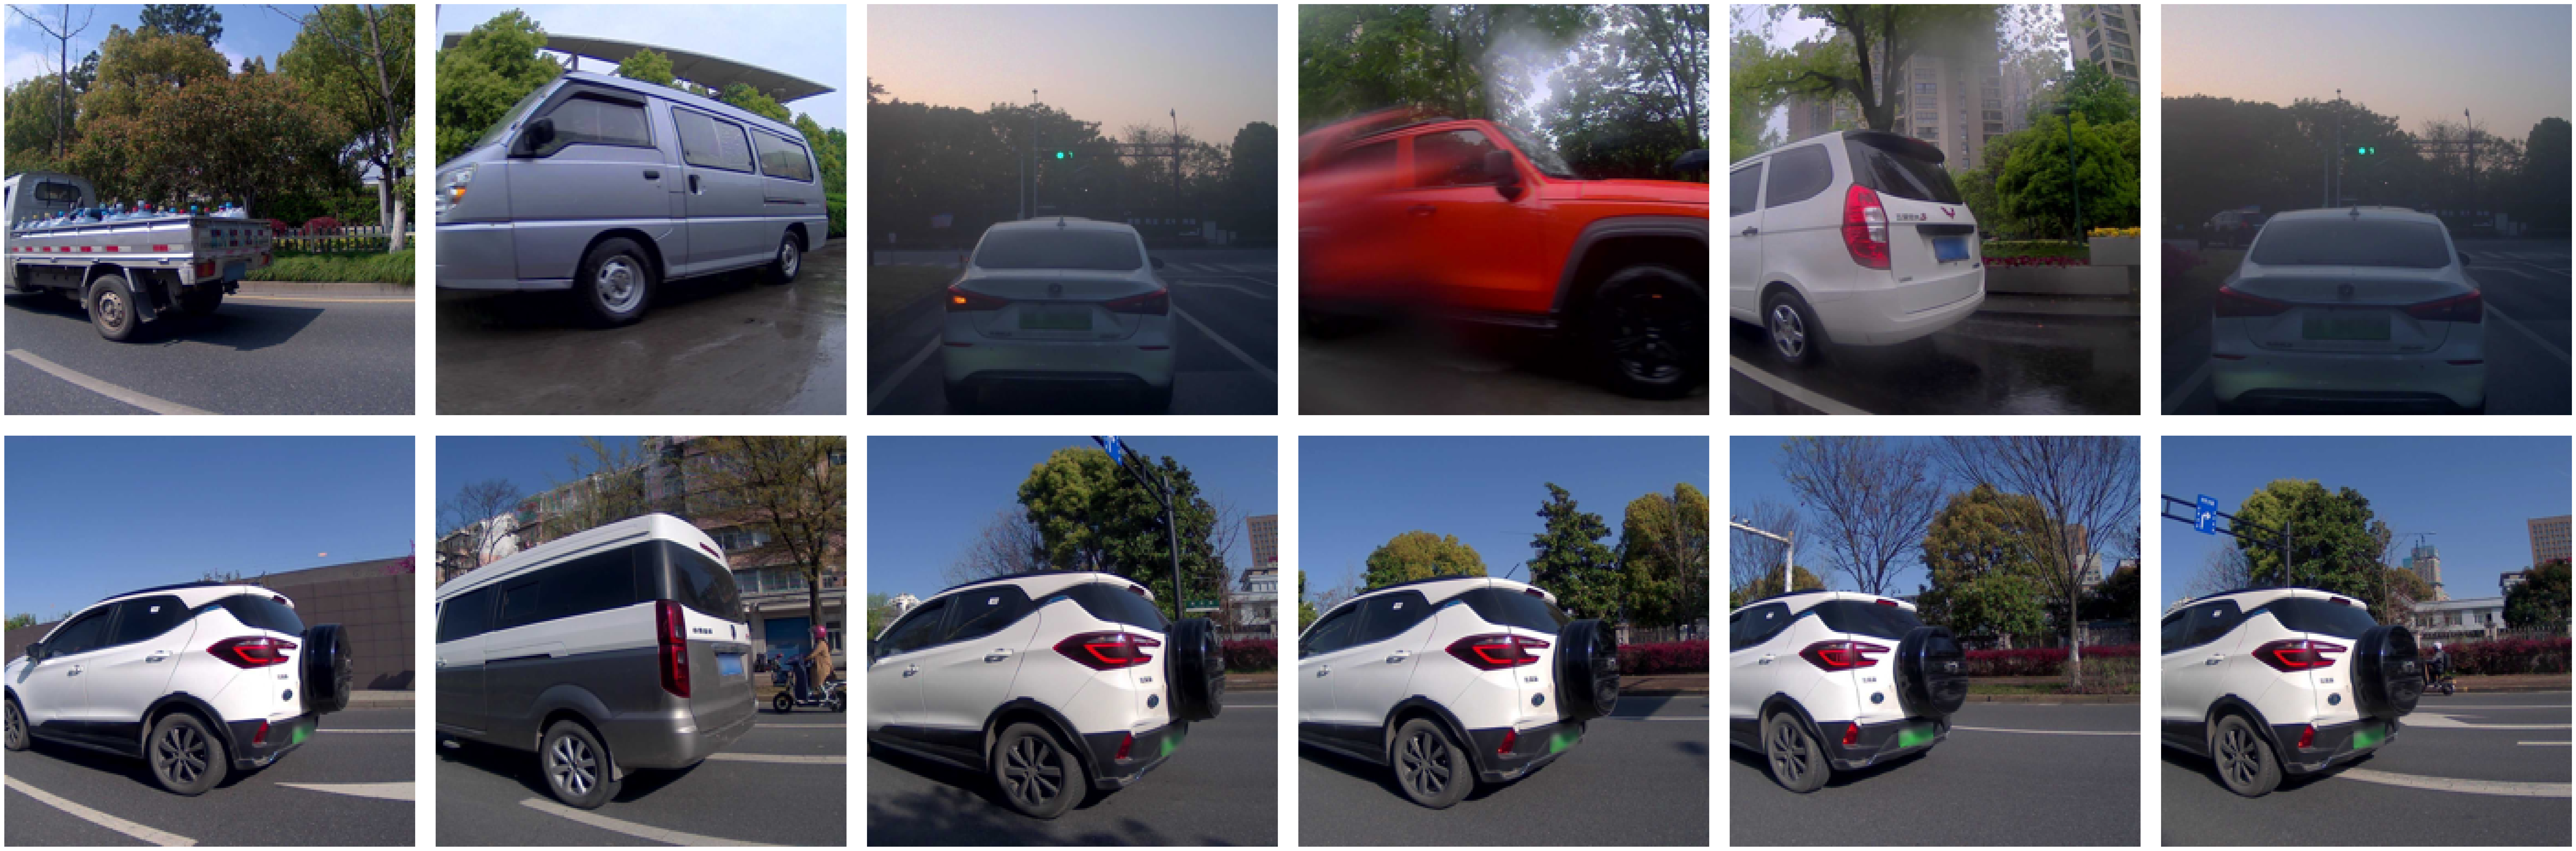

In [3]:
K2 = 6
image_prompts = ["an interesting looking vehicle"]
lidar_prompts = image_prompts
SUBSAMPLING = 1  # increase this to avoid picking extremely similar samples
img_idxs, pc_idxs, joint_idxs = get_topk_separate_prompts(image_prompts, lidar_prompts, K2, img_feats[::SUBSAMPLING], lidar_feats[::SUBSAMPLING])
pc_idxs = pc_idxs * SUBSAMPLING
img_idxs = img_idxs * SUBSAMPLING
joint_idxs = joint_idxs * SUBSAMPLING

PLOT_IMAGE = True
PLOT_LIDAR = True
PLOT_JOINT = False

rows = int(PLOT_IMAGE) + int(PLOT_LIDAR) + int(PLOT_JOINT)

fig = plt.figure(figsize=(10*K2,10*rows), dpi=200)
width, height = 1/K2, 1/(rows+0.1)
# ax = fig.add_axes([0, 0, 1, 1])

curr_row = 1
if PLOT_IMAGE:
    for i, idx in enumerate(img_idxs):
        ax = fig.add_axes([i/K2, 1/rows, width, height])
        ax.imshow((dataset[idx][0].permute(1,2,0)*stds + means).numpy())
        ax.axis('off')
    curr_row+=1

if PLOT_LIDAR:
    for i, idx in enumerate(pc_idxs):
        ax = fig.add_axes([i/K2, curr_row/rows, width, height])
        ax.imshow((dataset[idx][0].permute(1,2,0)*stds + means).numpy())
        ax.axis('off')
    curr_row+=1

if PLOT_JOINT:
    for i, idx in enumerate(joint_idxs):
        img, pc = dataset[idx][:2]

        # Draw the image
        ax = fig.add_axes([i/K2, 0, width, height])
        ax.imshow((img.permute(1,2,0)*stds + means).numpy())
        ax.axis('off')
        
        # Draw a miniature of the point cloud in the top corner
        ax = fig.add_axes([i/K2 + 1.96/K2/3, 1.93/3/rows, width/3, height/3])
        rect = patches.Rectangle((-10,4), 20, 16, alpha=1.0, facecolor='white')
        ax.add_patch(rect)
        pc = pc[pc[:,0] < 20]
        pc = pc[pc[:,1] < 10]
        pc = pc[pc[:,1] > -10]
        col = pc[:,3]
        ax.scatter(-pc[:,1], pc[:,0], s=0.1, c=col**0.3, cmap="coolwarm")
        ax.axis("scaled")
        ax.axis("off")
        ax.set_ylim(0, 20)
        ax.set_xlim(-10, 10)
    curr_row+=1

print(pc_idxs)
print(img_idxs)
print(joint_idxs)

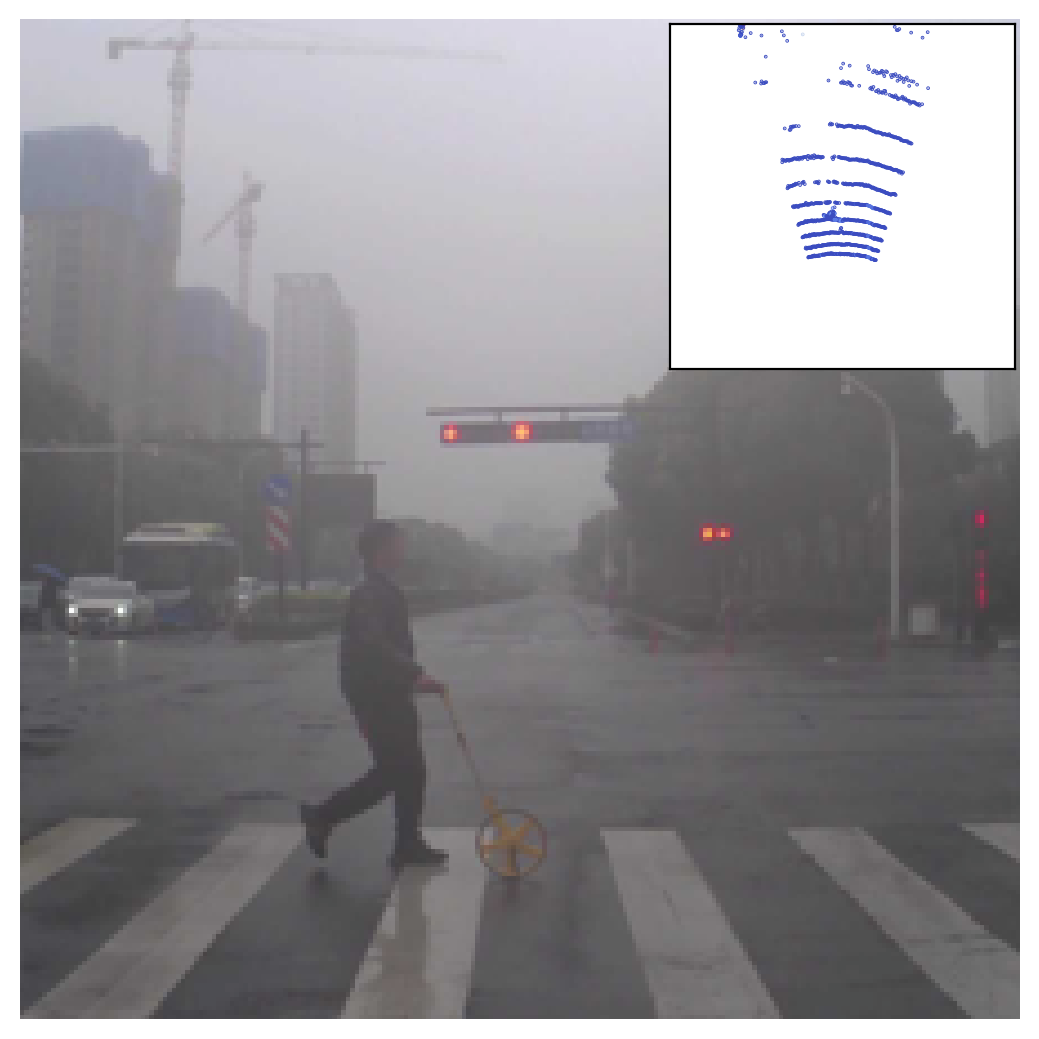

In [17]:
idx = 13406
img, pc = dataset[idx][:2]

fig = plt.figure(figsize=(5,5), dpi=200)

ax = fig.add_axes([0, 0, 1, 1])
ax.imshow((img.permute(1,2,0)*stds + means).numpy())
ax.axis('off')

ax = fig.add_axes([0.65, 0.65, 0.345, 0.345])
# draw the point cloud
pc = pc[pc[:,0] < 20]
pc = pc[pc[:,1] < 10]
pc = pc[pc[:,1] > -10]
col = pc[:,3]
ax.scatter(-pc[:,1], pc[:,0], s=0.1, c=col**0.3, cmap="coolwarm")
ax.axis("scaled")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, 20)
ax.set_xlim(-10, 10)

fig.savefig(f"img_{idx}.png")


In [18]:
idx = 65510 # 16367
torch.save(lidar_feats[idx].clone(), f"lidar_{idx}.pt")

In [ ]:
# # Save some figures for the paper
# for i, idx in enumerate(pc_idxs):
#     plt.imshow((dataset[idx][0].permute(1,2,0)*stds + means).numpy())
#     plt.axis('off')
#     plt.savefig("headlights_{}.png".format(i), bbox_inches='tight', pad_inches=0)

# Zero-Shot Classification

In [11]:
ZERO_SHOT_CLASSES =  ["vegetation", "building", "animal", "pedestrian", "cyclist", "bus", "truck", "car", "three-wheeler"]
CLASS_EMBEDDINGS = []
for cls_name in tqdm(ZERO_SHOT_CLASSES, "computing class embeddings..."):
    prompts = [template.format(cls_name) for template in OBJECT_PROMPT_TEMPLATES]
    with torch.no_grad():
        CLASS_EMBEDDINGS.append(clip_model.encode_text(clip.tokenize(prompts).to(device)).sum(axis=0, keepdim=True))
CLASS_EMBEDDINGS = torch.cat(CLASS_EMBEDDINGS, dim=0)

computing class embeddings...: 100%|██████████| 9/9 [03:19<00:00, 22.13s/it]


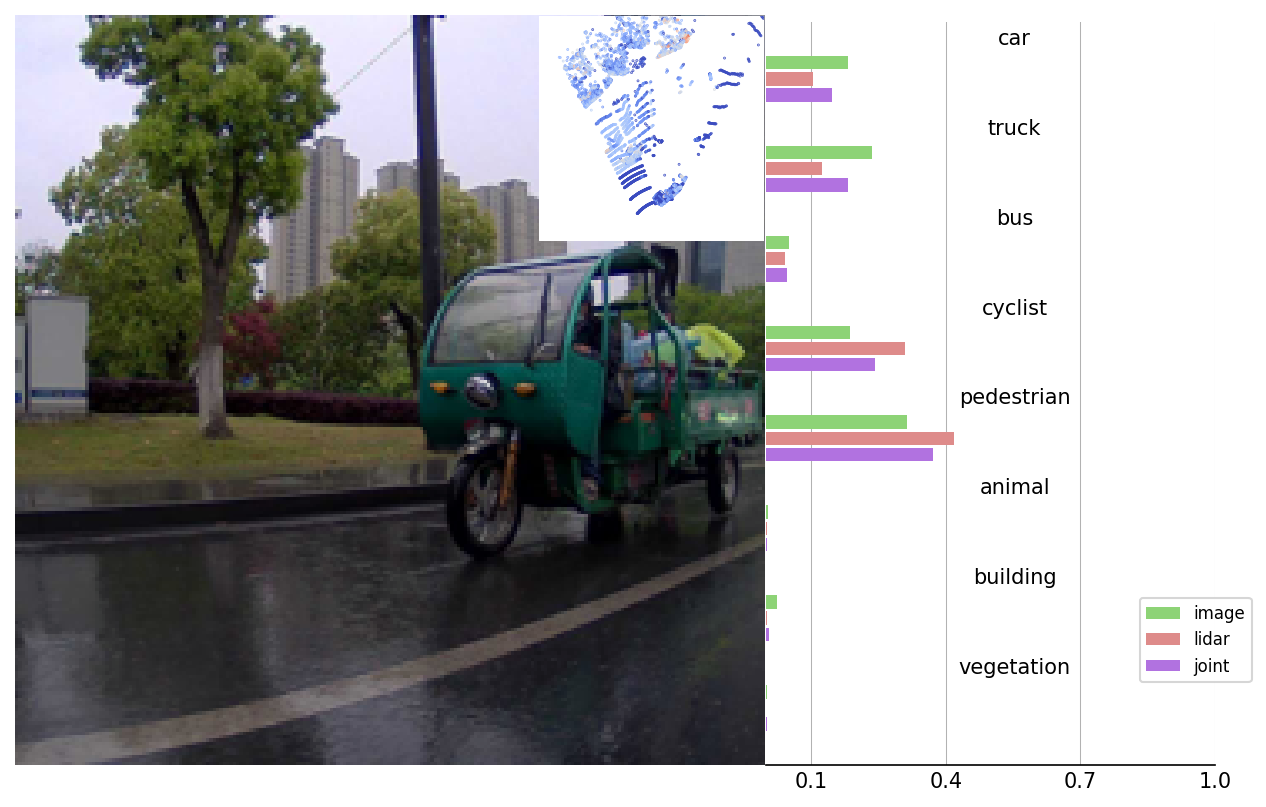

In [70]:
SAMPLE_IDXS = [
    61687,  # greenery
    0,      # bus
    1947,   # car
    8601,   # bus-car mix
    88888,  # nearby car
    58777,  # person biking
    113859, # moped
    13406,  # person walking unclear object
    96150,  # person with umbrella
    34170,  # person with backpack
    58854,  # doggo
    109737, # three-wheeler
]
lidar_feat = lidar_feats[SAMPLE_IDXS]
image_feat = img_feats[SAMPLE_IDXS]
joint_feat = joint_feats[SAMPLE_IDXS]

class_embeddings = CLASS_EMBEDDINGS
zero_shot_classes = ZERO_SHOT_CLASSES

with torch.no_grad():
    lidar_scores_all = logit_img_txt(lidar_feat, class_embeddings, clip_model)[0].softmax(0)
    image_scores_all = logit_img_txt(image_feat, class_embeddings, clip_model)[0].softmax(0)
    joint_scores_all = logit_img_txt(joint_feat, class_embeddings, clip_model)[0].softmax(0)

for i, sample_idx in enumerate(SAMPLE_IDXS):
    img, pc = dataset[sample_idx][:2]
    lidar_scores = lidar_scores_all[:, i]
    image_scores = image_scores_all[:, i]
    joint_scores = joint_scores_all[:, i]

    fig = plt.figure(figsize=(8,5), dpi=150)

    # Draw the image
    ax = fig.add_axes([0, 0, 5/8, 1])
    ax.imshow((img.permute(1,2,0)*stds + means).numpy())
    ax.axis('off')

    # Draw the point cloud
    ax = fig.add_axes([5/8-0.3 + 0.055, 0.698, 0.3, 0.3])
    rect = patches.Rectangle((-10,0), 20, 20, alpha=1.0, facecolor='white')
    ax.add_patch(rect)
    pc = pc[pc[:,0] < 20]
    pc = pc[pc[:,1] < 10]
    pc = pc[pc[:,1] > -10]
    col = pc[:,3]
    ax.scatter(-pc[:,1], pc[:,0], s=0.1, c=col**0.3, cmap="coolwarm")
    ax.axis("scaled")
    ax.axis("off")
    ax.set_ylim(0, 20)
    ax.set_xlim(-10, 10)

    # Draw the class bar chart
    ax = fig.add_axes([5/8+0.001, 0.0, 3/8-0.001, 0.99])
    # plot class scores as a horizontal bar chart with image lidar and joint scores side by side
    # top down not down up
    # draw vertical grid lines behind the bars
    ax.grid(axis='x', linestyle='-', linewidth=0.5, color='black', alpha=0.3)    
    ax.set_axisbelow(True)
    ax.set_yticks(np.arange(len(zero_shot_classes))+0.65)
    ax.set_yticklabels(zero_shot_classes, fontsize=8)
    ax.set_xticks([0.1, 0.4, 0.7, 1.0])
    ax.yaxis.tick_right()
    # get the width of the axis in pixels
    ax_width = ax.get_window_extent().width
    ax.tick_params(axis="y", direction="in", pad=-ax_width/4+16, labelsize=10, length=0)
    # Draw a white background around the tick labels
    for label in ax.get_yticklabels():
        label.set_bbox(dict(facecolor='white', edgecolor='none', pad=2))
        label.set_horizontalalignment('center')

    ax.tick_params(axis="x", direction='inout', length=0)
    ax.set_xlim(0, 1)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False) 
    ax.spines.top.set_visible(False)
    ax.barh(np.arange(len(zero_shot_classes)) + 0.36, image_scores, height=0.15, color='#8DD376', label='image')
    ax.barh(np.arange(len(zero_shot_classes)) + 0.18, lidar_scores, height=0.15, color='#DE8B8A', label='lidar')
    ax.barh(np.arange(len(zero_shot_classes)) , joint_scores, height=0.15, color='#B172E0', label='joint')
    ax.legend(loc='lower right', bbox_to_anchor=(1.1, 0.1), fontsize=8)
    fig.savefig("zero_shot_{}.png".format(sample_idx), bbox_inches='tight', pad_inches=0)


In [ ]:
# FIST_PAGE_IDX = 109737

# # Draw the image
# plt.imshow(dataset[FIST_PAGE_IDX][0].permute(1,2,0)*stds + means)
# plt.axis("off")
# plt.savefig("front_page_image.png", bbox_inches='tight', pad_inches=0)

# # Draw the point cloud
# plt.figure(figsize=(5,5), dpi=200)
# pc  = dataset[FIST_PAGE_IDX][1].numpy()
# pc = pc[pc[:,0] < 20]
# pc = pc[pc[:,1] < 10]
# pc = pc[pc[:,1] > -10]
# col = pc[:,3]
# plt.scatter(-pc[:,1], pc[:,0], s=0.1, c=col**0.3, cmap="coolwarm")
# plt.axis("scaled")
# plt.axis("off")
# plt.ylim(0, 20)
# plt.xlim(-10, 10)
# plt.savefig("front_page_lidar.png", bbox_inches='tight', pad_inches=0)